## Projeto 1: Clusterização com PCA e K-means

### 1. Importar Bibliotecas e Carregar os Dados

In [43]:

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Carregar o arquivo Excel
file_path = 'base_completa.xlsx'
df = pd.read_excel(file_path, sheet_name='Planilha1')
df.head()


Situação                                    Motivo  \
0                      Não Contato                   Respondido - Incompleta   
1             Respondeu à Pesquisa                                   OCUPADO   
2                       Em Contato                                INCOMPLETO   
3  Inconsistência Carga do Arquivo  Msg: Operadora/Caixa Postal Não Atendida   
4                       Em Contato                      Tentativas Excedidas   

            SAC Canal  SAC Gest Resp Ouvidoria           SAC Ass Problema  \
0        2ª Instância                     8629                     Fraude   
1        2ª Instância                     4010            Compra/rotativo   
2              Online                     4010            Compra/rotativo   
3          SAC Direto                     8629  Contestação de lançamento   
4  Central Telefônica                     8747                     Fraude   

      SAC Sit Manifestação                SAC Via Entrada SAC Via Solução  \
0    PROCEDENTE SEM ACORDO                       INTERNET        TELEFONE   
1  IMPROCEDENTE COM ACORDO            RECHAMADA OUVIDORIA          E-MAIL   
2    PROCEDENTE SEM ACORDO  CENTRAL ATENDIMENTO OUVIDORIA          E-MAIL   
3    PROCEDENTE COM ACORDO                       INTERNET          E-MAIL   
4    PROCEDENTE SEM ACORDO            RECHAMADA OUVIDORIA        TELEFONE   

   Tempo de Jornada (dias)      Satisfação  
0                       21               4  
1                        8               2  
2                       17               5  
3                       18  Não Respondido  
4                       18               4

### 2. Pré-processamento dos Dados

In [44]:

numeric_features = ['Tempo de Jornada (dias)']
categorical_features = [col for col in df.columns if col not in numeric_features]

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Aplicar as transformações
X_preprocessed = preprocessor.fit_transform(df)
X_preprocessed_dense = X_preprocessed.toarray()


### 3. Análise de PCA para Variáveis Importantes

In [45]:

pca = PCA()
X_pca = pca.fit_transform(X_preprocessed_dense)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
cumulative_variance


array([0.12314704, 0.16735709, 0.20891562, 0.24399119, 0.27659194,
       0.30875377, 0.33927422, 0.36928227, 0.39747762, 0.42548937,
       0.45236192, 0.47758896, 0.50238483, 0.5267834 , 0.55090015,
       0.57360107, 0.59517294, 0.61614612, 0.63665091, 0.65661483,
       0.67552779, 0.69388085, 0.71181456, 0.72957891, 0.74646464,
       0.7627021 , 0.77868256, 0.79377348, 0.80843918, 0.82246558,
       0.83594044, 0.84916127, 0.86199269, 0.87407117, 0.88591905,
       0.89739047, 0.90852581, 0.91912972, 0.92932599, 0.93941628,
       0.94939788, 0.95876922, 0.96755622, 0.97621331, 0.98474783,
       0.99258363, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [46]:
# Analisando as cargas (loadings) dos componentes principais
loadings = pd.DataFrame(
    pca.components_.T, 
    index=preprocessor.get_feature_names_out(), 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
loadings_abs = loadings.abs()

# Calculando a importância de cada variável somando os valores absolutos das cargas
variable_importance = loadings_abs.sum(axis=1).sort_values(ascending=False)

# Mostrar as 10 variáveis mais importantes
variable_importance.head(10)

cat__SAC Ass Problema_Não recebimento do cartão    5.927398
cat__SAC Canal_Central Telefônica                  5.886917
cat__SAC Ass Problema_Pagamento                    5.785879
cat__Motivo_Respondido - Completa                  5.784567
cat__SAC Ass Problema_Compra/rotativo              5.741930
cat__SAC Ass Problema_Fraude                       5.680186
cat__SAC Gest Resp Ouvidoria_5404                  5.651612
cat__Motivo_Sem telefones válido para contato      5.606472
cat__SAC Gest Resp Ouvidoria_4859                  5.600386
cat__SAC Via Entrada_RECHAMADA OUVIDORIA           5.599112
dtype: float64

### 4. Método do Cotovelo para Determinar o Número de Clusters

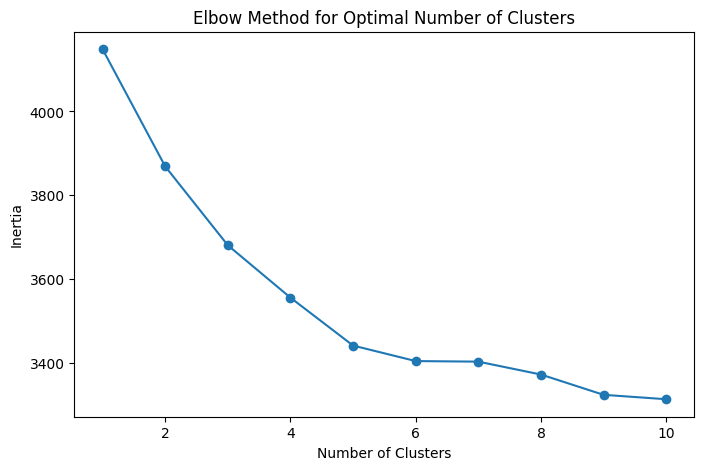

In [47]:

inertia = []
range_n_clusters = range(1, 11)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed_dense)
    inertia.append(kmeans.inertia_)

# Plotar curva do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


### 5. Aplicar K-means com 3 Clusters

In [48]:

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_preprocessed_dense)
df['Cluster'] = clusters


### 6. Análise Detalhada de Cada Cluster

In [49]:

cluster_summary = df.groupby('Cluster').agg({
    'Situação': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',
    'Motivo': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',
    'SAC Canal': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',
    'SAC Ass Problema': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',
    'Tempo de Jornada (dias)': 'mean',
    'Satisfação': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',
    'Cluster': 'size'
}).rename(columns={'Cluster': 'Count'})
cluster_summary


Situação                   Motivo  \
Cluster                                                             
0        Inconsistência Carga do Arquivo    Respondido - Completa   
1        Inconsistência Carga do Arquivo  Respondido - Incompleta   
2                             Em Contato    Respondido - Completa   
3                            Não Contato                  OCUPADO   

            SAC Canal           SAC Ass Problema  Tempo de Jornada (dias)  \
Cluster                                                                     
0          SAC Direto                  Pagamento                 4.115385   
1        2ª Instância            Compra/rotativo                13.980392   
2        2ª Instância  Não recebimento do cartão                24.179487   
3        1ª Instância  Não recebimento do cartão                14.335714   

        Satisfação  Count  
Cluster                    
0                1     78  
1                4    204  
2                2     78  
3                4    140